In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings("ignore")
plt.style.use('seaborn-deep')

In [2]:
import sys
sys.path.append("../")

In [3]:
from src.utils import *

In [4]:
data = "../data/processed/cleaned_train.csv"
df = pd.read_csv(data, index_col=0)
df.head()

,ID,Gender,Ever_Married,Graduated,Profession,Spending_Score,Family_Size,Var_1,Segmentation,Age,Work_Experience
0,462809,Male,No,No,Healthcare,Low,4.0,Cat_4,D,22.0,1.0
1,462643,Female,Yes,Yes,Engineer,Average,3.0,Cat_4,A,38.0,6.0
2,466315,Female,Yes,Yes,Engineer,Low,1.0,Cat_6,B,67.0,1.0
3,461735,Male,Yes,Yes,Lawyer,High,2.0,Cat_6,B,67.0,0.0
4,462669,Female,Yes,Yes,Entertainment,High,6.0,Cat_6,A,40.0,4.0


In [5]:
cat_cols, num_cols = separate_categorical_numerical(df.drop("ID", axis=1))
print(cat_cols, num_cols)

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1', 'Segmentation'],
      dtype='object') Index(['Family_Size', 'Age', 'Work_Experience'], dtype='object')


In [6]:
# Group the categorical columns in the pandas DataFrame into pairs.
# Then, create a contingency table for all those related to segmentation. 

seg_col = 'Segmentation'
col_pairs = [(seg_col, col) for col in cat_cols if col != seg_col]

print(col_pairs)

contingency_tables = pd.DataFrame()
for pair in col_pairs:
    cols = []
    col1, col2 = pair

    cols.append(col1)
    cols.append(col2)

    contingency_table = create_contingency_tables(df[cols])
    contingency_table = contingency_table.loc[df["Segmentation"].unique()].dropna(axis=1)
    contingency_table = pd.DataFrame(contingency_table)

    contingency_tables = pd.concat([contingency_tables, contingency_table], axis=1)

[('Segmentation', 'Gender'), ('Segmentation', 'Ever_Married'), ('Segmentation', 'Graduated'), ('Segmentation', 'Profession'), ('Segmentation', 'Spending_Score'), ('Segmentation', 'Var_1')]


In [7]:
# Set the maximum number of rows to display
pd.options.display.max_rows = None

# Set the maximum number of columns to display
pd.options.display.max_columns = None

In [8]:
contingency_tables = contingency_tables.reindex(index=["A", "B", "C", "D"])
contingency_tables

Segmentation x Gender         Segmentation x Ever_Married          \
                 Female    Male                          No     Yes   
A                 816.0   971.0                       730.0  1057.0   
B                 799.0   940.0                       460.0  1279.0   
C                 863.0   997.0                       370.0  1490.0   
D                 820.0  1170.0                      1446.0   544.0   

  Segmentation x Graduated         Segmentation x Profession                  \
                        No     Yes                    Artist Doctor Engineer   
A                    662.0  1125.0                     520.0  184.0    239.0   
B                    485.0  1254.0                     719.0  137.0    176.0   
C                    317.0  1543.0                    1018.0  134.0     73.0   
D                   1264.0   726.0                     128.0  191.0    161.0   

                                                                 \
  Entertainment Executive Healthcare Homemaker Lawyer Marketing   
A         338.0     114.0      101.0      62.0  179.0      50.0   
B         208.0     173.0       98.0      50.0  148.0      30.0   
C         139.0     174.0      132.0      24.0  133.0      33.0   
D         196.0     105.0      877.0      71.0  111.0     150.0   

  Segmentation x Spending_Score                Segmentation x Var_1         \
                        Average   High     Low                Cat_1  Cat_2   
A                         310.0  248.0  1229.0                 26.0   78.0   
B                         554.0  361.0   824.0                 24.0   98.0   
C                         862.0  396.0   602.0                 24.0   94.0   
D                         118.0  126.0  1746.0                 45.0  125.0   

                                     
   Cat_3  Cat_4 Cat_5   Cat_6 Cat_7  
A  194.0  294.0  16.0  1133.0  46.0  
B  173.0  214.0  20.0  1169.0  41.0  
C  131.0   99.0  18.0  1449.0  45.0  
D  214.0  359.0  21.0  1173.0  53.0

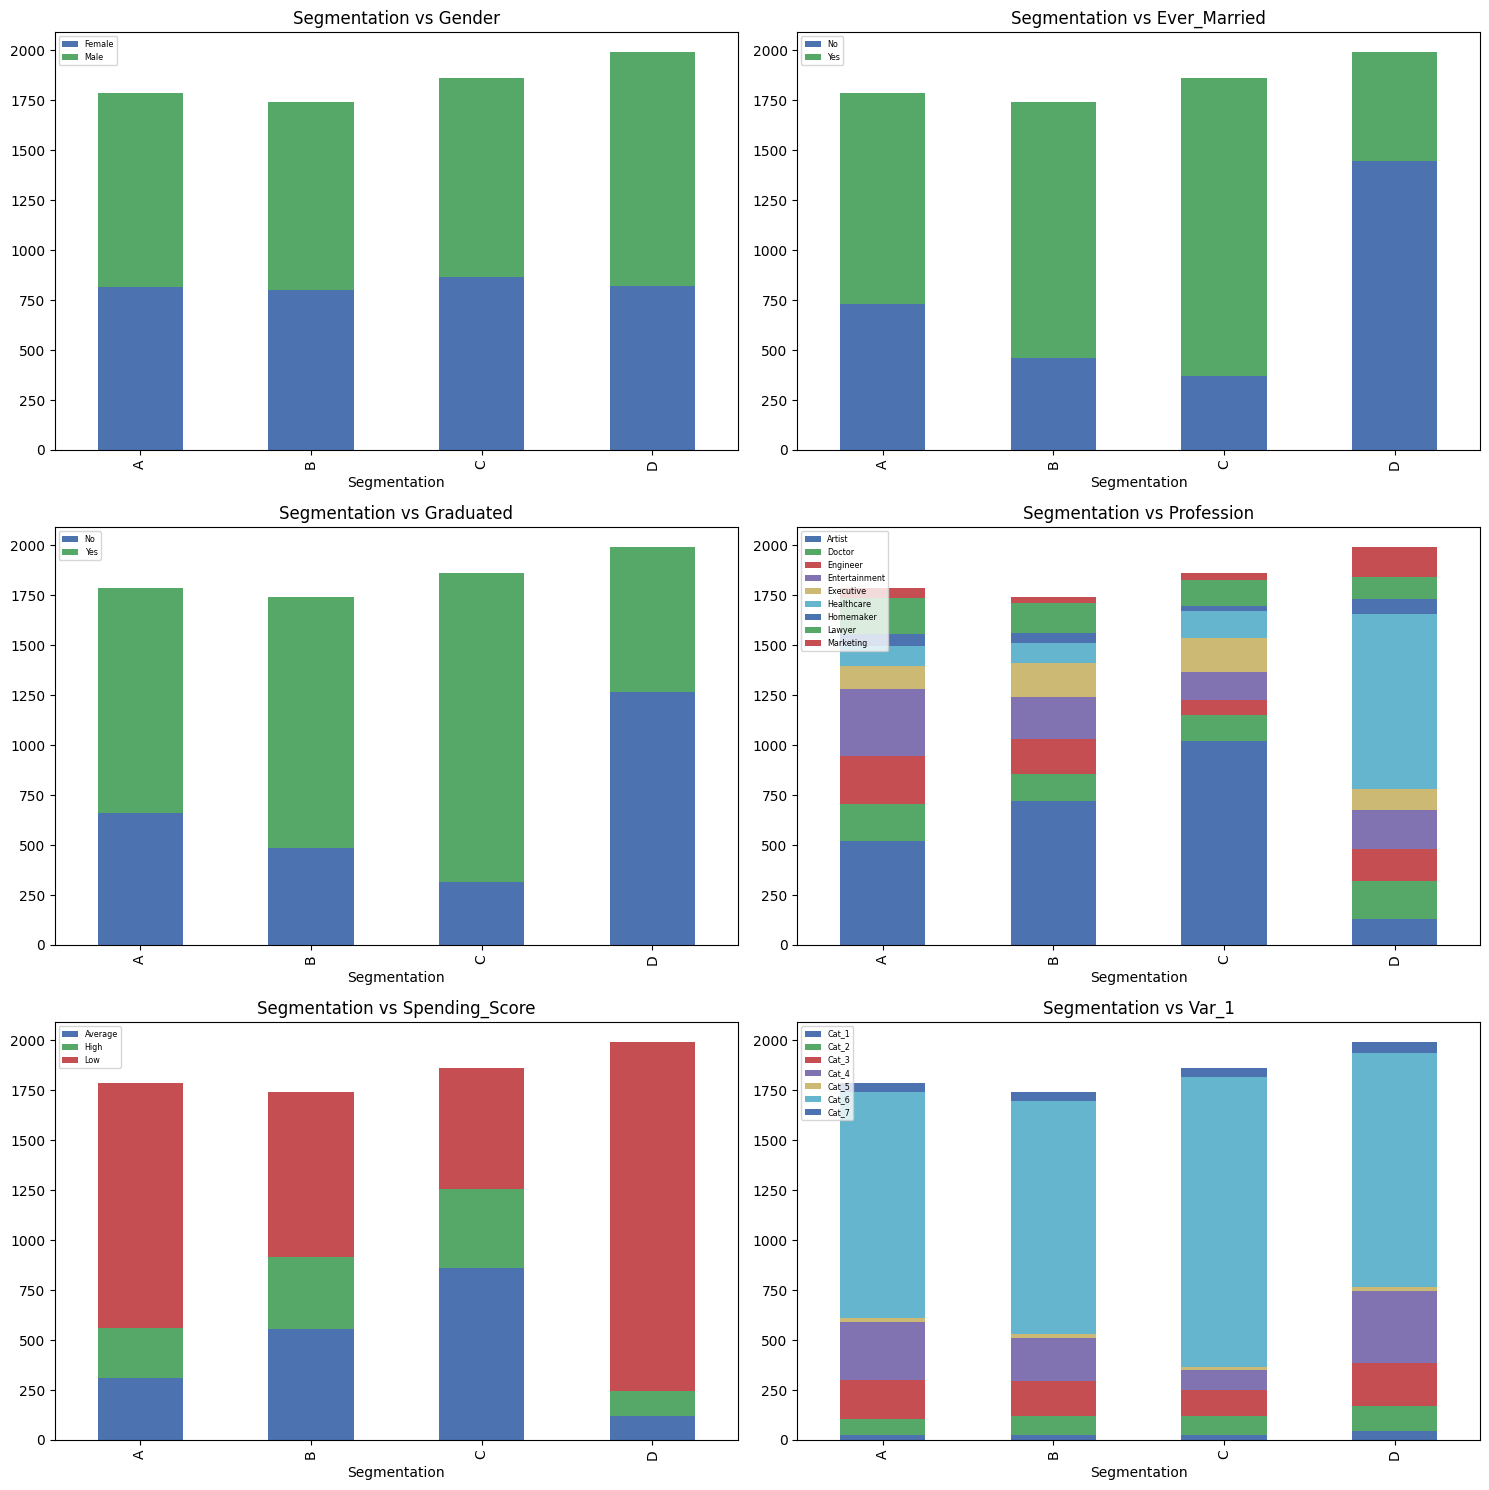

In [9]:
plot_categorical_comparison(df, "Segmentation")

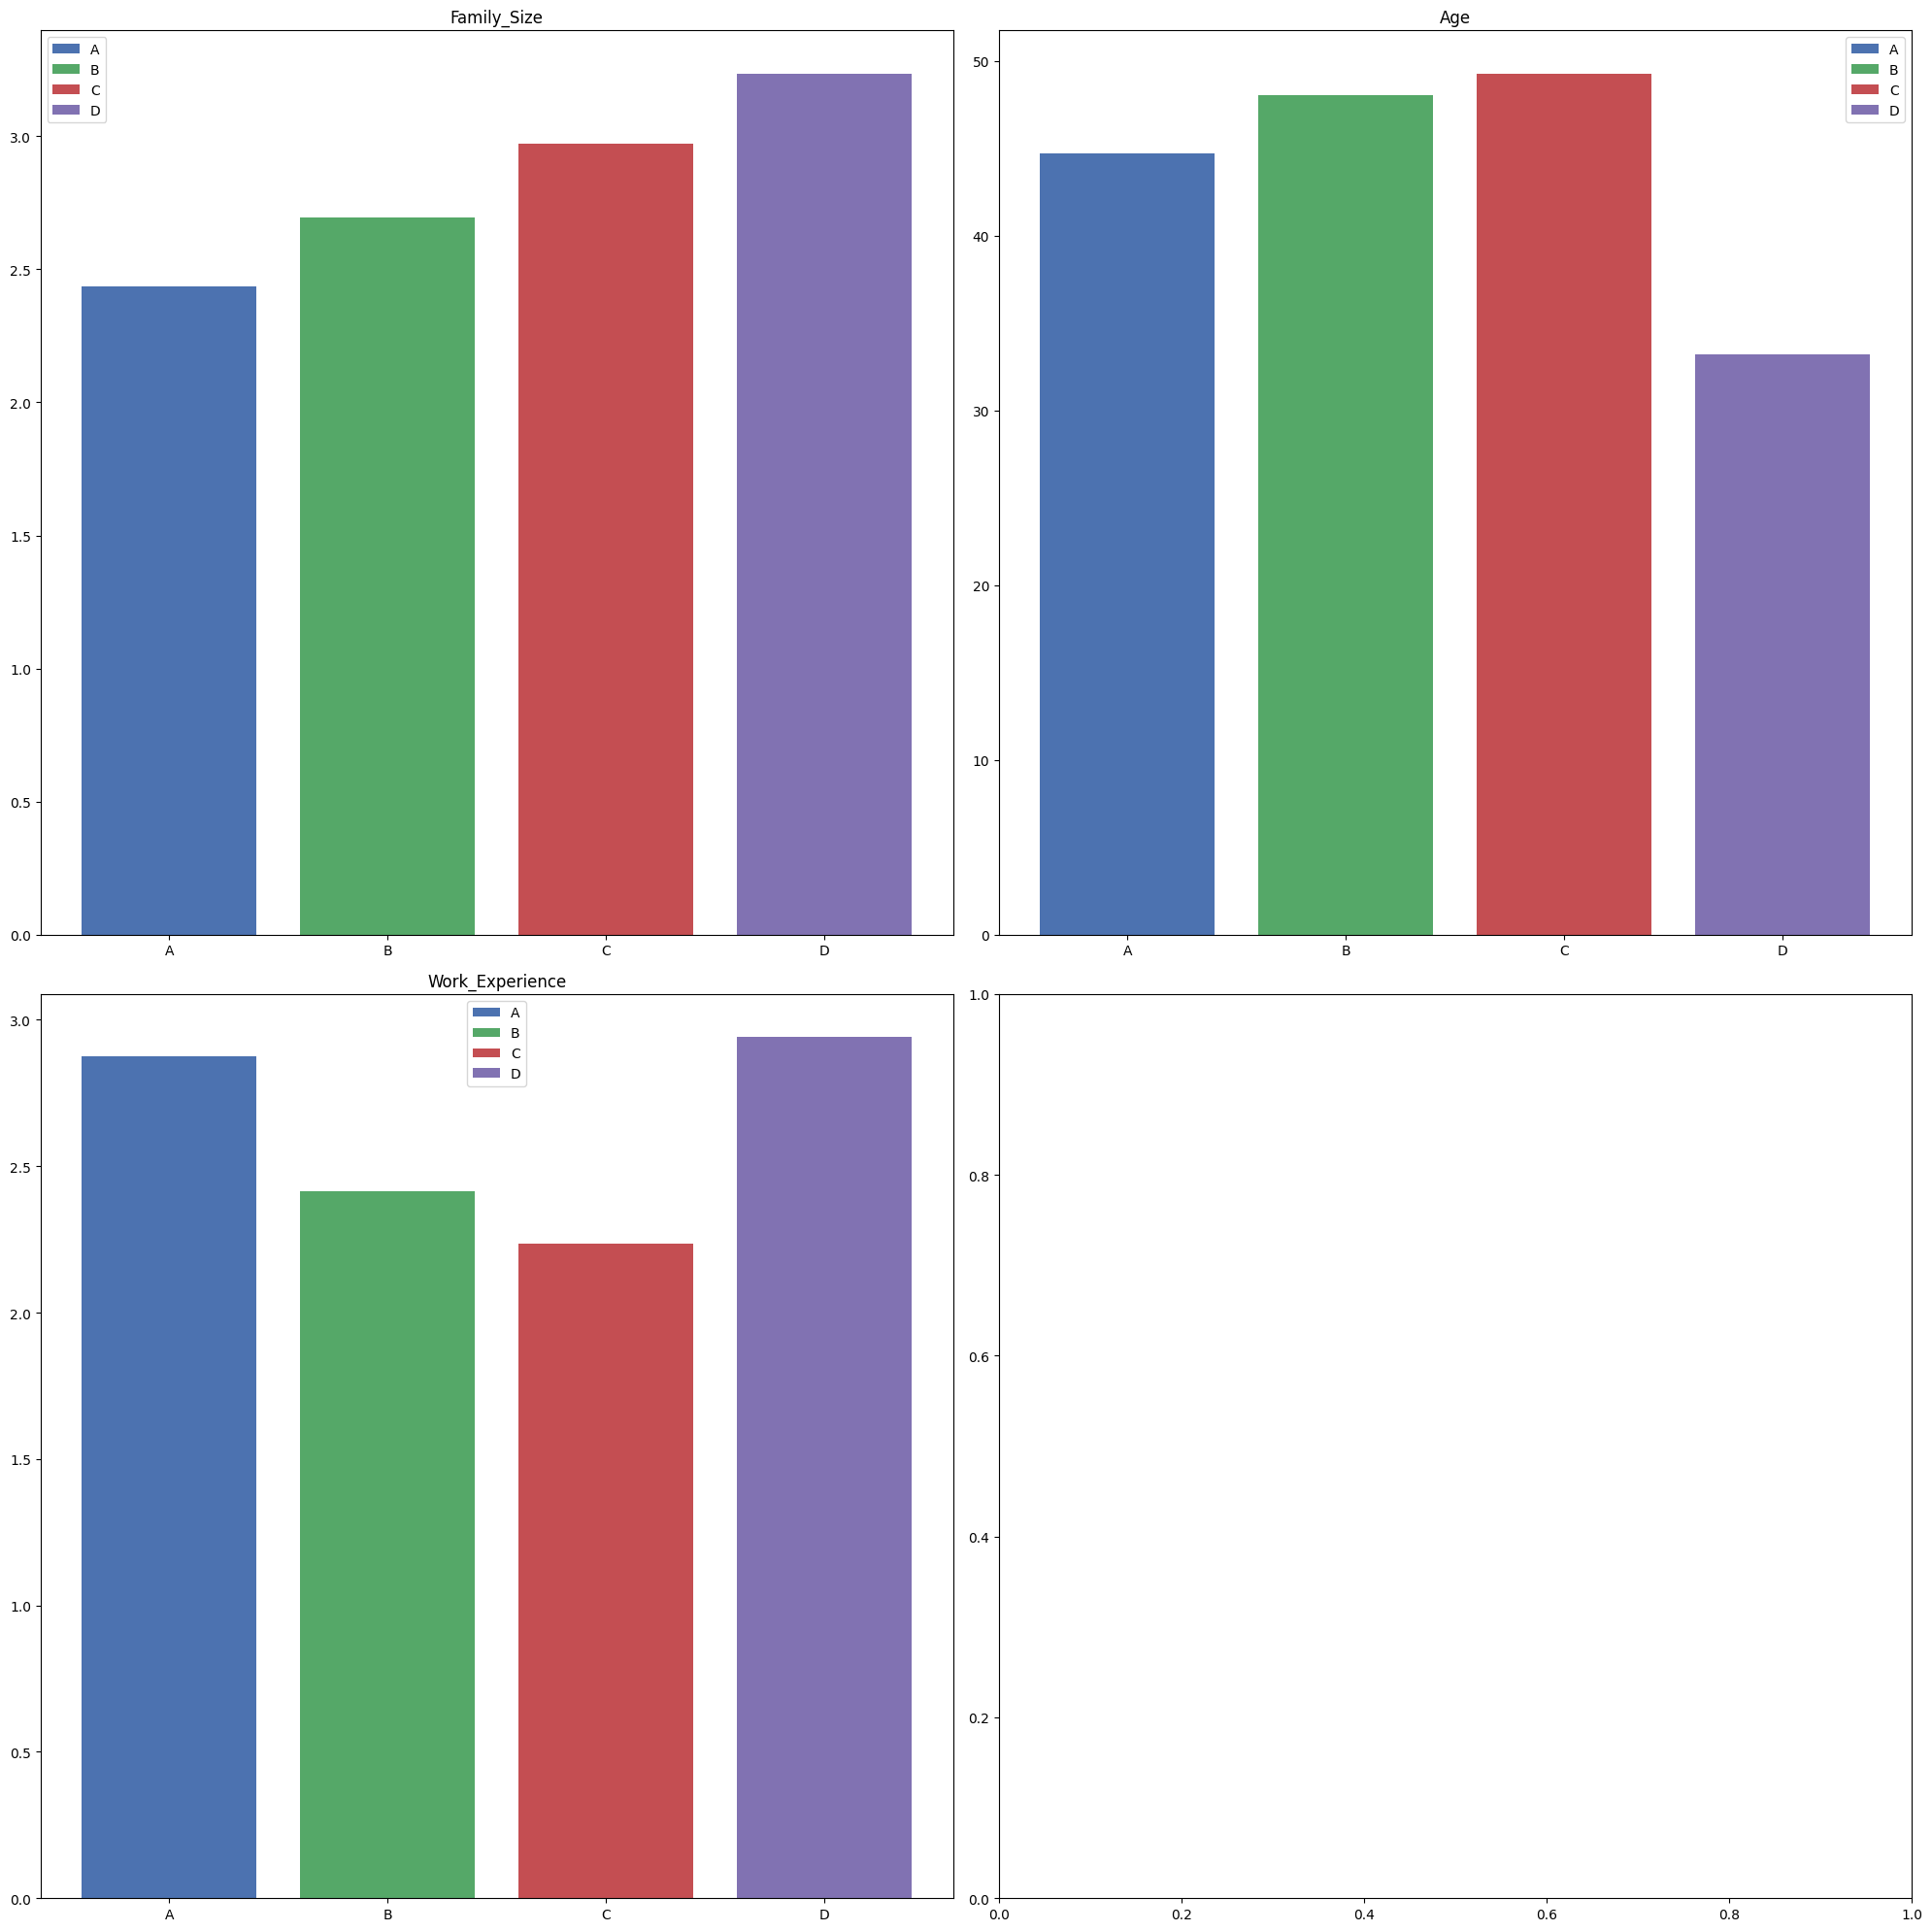

In [10]:
plot_categorical_numerical_comparison(df, "Segmentation")

Family_Size


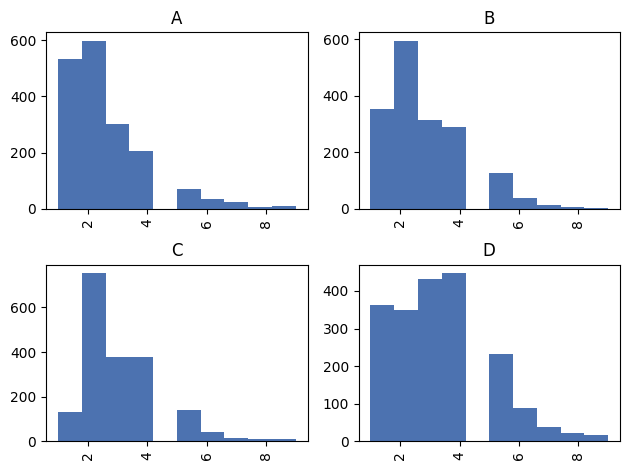

Age


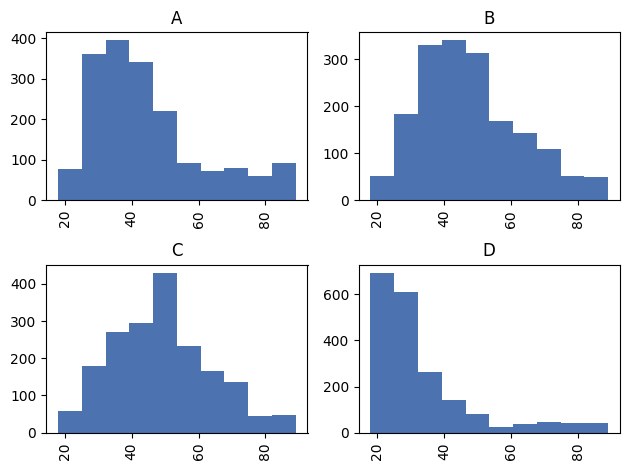

Work_Experience


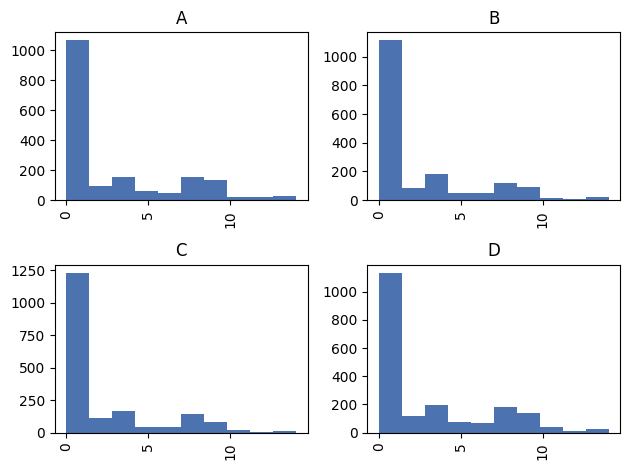

In [11]:
plot_distributions(df.drop("ID", axis=1), "Segmentation")